In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Model
from keras import regularizers
from keras.layers import Input, Dense, Lambda
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, confusion_matrix, matthews_corrcoef
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

# configure Keras to use GPU
tf.config.experimental.set_visible_devices([], 'GPU')

2023-05-09 08:25:54.188847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data
transactions = pd.read_csv('/Users/user/Documents/datasets/ieee/train_transaction.csv', index_col='TransactionID')
identity = pd.read_csv('/Users/user/Documents/datasets/ieee/train_identity.csv', index_col='TransactionID')
data = transactions.merge(identity, how='left', left_index=True, right_index=True)

In [3]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('isFraud', axis=1),
    data['isFraud'],
    test_size=0.2,
    random_state=42
)

In [4]:
# Data preprocessing
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]
for col in categorical_cols:
    X_train[col] = X_train[col].fillna('unknown')
    X_test[col] = X_test[col].fillna('unknown')
    le = LabelEncoder()
    le.fit(list(X_train[col].values) + list(X_test[col].values))
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [5]:
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [6]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [7]:
# Create a Contractive Autoencoder to generate synthetic fraud data
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2)

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

# Define the Contractive loss function
def contractive_loss(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    w = 1e-4 # weight given to the jacobian regularizer
    contractive_reg = K.sum(K.square(K.gradients(y_pred, encoder)[0]), axis=1)
    return mse + w * contractive_reg

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Train the autoencoder on normal transactions
X_normal = X_train[y_train == 0]
X_normal_train, X_normal_test = train_test_split(X_normal, test_size=0.2, random_state=42)

autoencoder.compile(optimizer='adam', loss=contractive_loss)
history = autoencoder.fit(X_normal_train, X_normal_train, epochs=100, batch_size=32, validation_data=(X_normal_test, X_normal_test))

# Generate synthetic fraud transactions using the trained autoencoder
X_fraud = X_train[y_train == 1]
synthetic_fraud = autoencoder.predict(X_fraud)

noise_factor = 0.2
encoded_normal_noisy = synthetic_fraud + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=synthetic_fraud.shape)
synthetic_fraud_data = autoencoder.predict(encoded_normal_noisy)

# Combine the synthetic fraud transactions with the original fraud transactions
X_fraud = np.vstack((X_fraud, synthetic_fraud_data))

# Combine the normal transactions with the fraud transactions
X_balanced = np.vstack((X_normal, X_fraud))
y_balanced = np.hstack((np.zeros(X_normal.shape[0]), np.ones(X_fraud.shape[0])))

Train on 364808 samples, validate on 91203 samples
Epoch 1/100
   224/364808 [..............................] - ETA: 7:00 - loss: 6935.7097 

2023-05-09 08:27:36.193275: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense_1/bias/m/Assign' id:351 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/m, training/Adam/dense_1/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


364672/364808 [============================>.] - ETA: 0s - loss: 3250.0588

/Users/user/Library/Python/3.9/lib/python/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-05-09 08:28:17.177106: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/AddN' id:146 op device:{requested: '', assigned: ''} def:{{{node loss/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, dense/ActivityRegularizer/truediv)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


364808/364808 [==============================] - 46s 126us/sample - loss: 3249.1505 - val_loss: 821.3665
Epoch 2/100
364808/364808 [==============================] - 44s 120us/sample - loss: 181.9913 - val_loss: 10.4470
Epoch 3/100
364808/364808 [==============================] - 44s 120us/sample - loss: 8.0137 - val_loss: 6.3919
Epoch 4/100
364808/364808 [==============================] - 43s 119us/sample - loss: 6.1819 - val_loss: 4.8806
Epoch 5/100
364808/364808 [==============================] - 42s 116us/sample - loss: 5.1271 - val_loss: 4.2378
Epoch 6/100
364808/364808 [==============================] - 42s 115us/sample - loss: 4.6025 - val_loss: 4.0405
Epoch 7/100
364808/364808 [==============================] - 43s 117us/sample - loss: 4.5002 - val_loss: 4.1993
Epoch 8/100
364808/364808 [==============================] - 42s 115us/sample - loss: 4.2675 - val_loss: 4.3838
Epoch 9/100
364808/364808 [==============================] - 43s 118us/sample - loss: 4.3053 - val_loss: 4.2

364808/364808 [==============================] - 28s 77us/sample - loss: 2.7931 - val_loss: 3.6251
Epoch 75/100
364808/364808 [==============================] - 26s 71us/sample - loss: 2.6760 - val_loss: 2.7020
Epoch 76/100
364808/364808 [==============================] - 26s 71us/sample - loss: 2.6632 - val_loss: 2.6166
Epoch 77/100
364808/364808 [==============================] - 27s 74us/sample - loss: 2.6926 - val_loss: 2.4163
Epoch 78/100
364808/364808 [==============================] - 29s 80us/sample - loss: 2.7250 - val_loss: 2.7047
Epoch 79/100
364808/364808 [==============================] - 27s 74us/sample - loss: 2.8210 - val_loss: 2.6256
Epoch 80/100
364808/364808 [==============================] - 27s 74us/sample - loss: 2.6402 - val_loss: 2.8063
Epoch 81/100
364808/364808 [==============================] - 28s 75us/sample - loss: 2.8224 - val_loss: 2.4013
Epoch 82/100
364808/364808 [==============================] - 27s 74us/sample - loss: 2.5549 - val_loss: 2.3704
Epoch

/Users/user/Library/Python/3.9/lib/python/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-09 09:21:59.792722: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_3/Relu' id:110 op device:{requested: '', assigned: ''} def:{{{node dense_3/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [8]:
# Resample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_balanced, y_balanced)

In [9]:
# Train a random forest classifier on the resampled training data
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [10]:
# Make predictions on the testing data
y_pred = model.predict(X_test.fillna(0))

/Users/user/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [11]:
# Calculate the accuracy and other performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = recall

Accuracy: 0.97905307007146
Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.91      0.46      0.61      4242

    accuracy                           0.98    118108
   macro avg       0.94      0.73      0.80    118108
weighted avg       0.98      0.98      0.98    118108

Confusion matrix:
[[113668    198]
 [  2276   1966]]


In [12]:
#predict the class probabilities
y_pred_proba = model.predict_proba(X_test.fillna(0))[:, 1]

/Users/user/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [13]:
#calculate the AUC value
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred_proba)
print("F1-score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)
print("AUC: ", auc)

F1-score:  0.6137995629097721
Precision:  0.9085027726432532
Recall:  0.46346063177746344
Specificity:  0.9982611139409482
Sensitivity:  0.46346063177746344
AUC:  0.9293231983154504


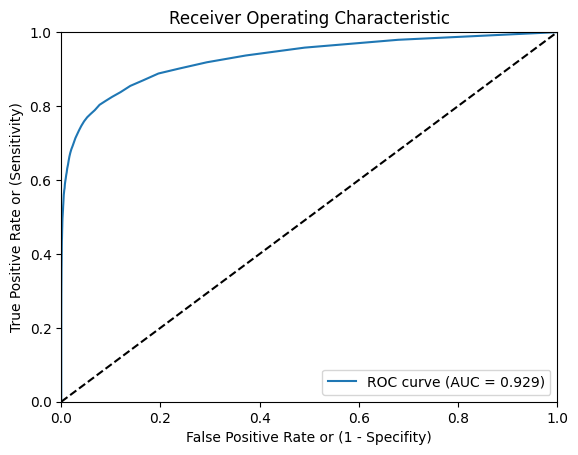

In [14]:
# calculate & plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %f" % accuracy)

Accuracy: 0.979053


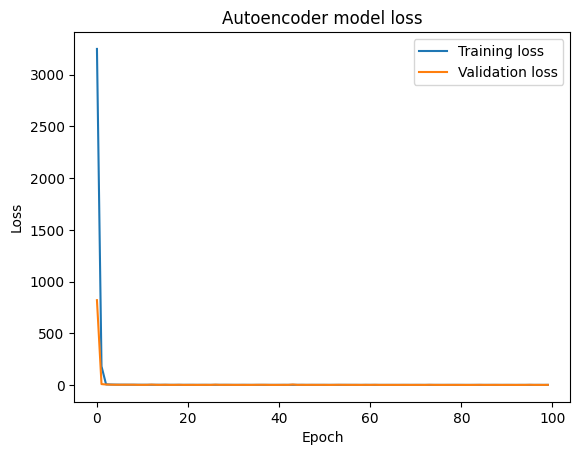

In [16]:
# plot the loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Autoencoder model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [17]:
mcc = matthews_corrcoef(y_test, y_pred)

print("Matthews correlation coefficient:", mcc)

Matthews correlation coefficient: 0.6406339138135007
